# Setup locale

In [3]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Path su linux
file_path = './data/Dataset3_PortfolioReplicaStrategy.xlsx'

# Path su windows - comando da inserire 
#file_path = "C:/Users/pc/Desktop/politecnico/b-FINTECH/business cases/Fintech_BC/BC2/data/Dataset2_Needs.xls"

# Data Preprocessing


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading the Excel file with specific structure:
# - Row 4 contains full names
# - Row 6 contains Bloomberg tickers (note: Excel is 1-indexed, pandas is 0-indexed)
# - Data starts from row 7

# Read full names (row 4)
full_names_df = pd.read_excel(file_path, header=None, skiprows=3, nrows=1)
full_names = full_names_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Read Bloomberg tickers (row 6)
tickers_df = pd.read_excel(file_path, header=None, skiprows=5, nrows=1)
tickers = tickers_df.iloc[0].tolist()[1:]  # Skip the first column (date column)

# Create a dictionary mapping tickers to full names
variable_info = dict(zip(tickers, full_names))

# Read the actual data without using any row as a header
data_raw = pd.read_excel(file_path, header=None, skiprows=6)

# First column is the date column
data_raw.columns = ['Date'] + tickers  # Assign the columns correctly using tickers

# Set the date column as the index and ensure it's in datetime format
data_raw['Date'] = pd.to_datetime(data_raw['Date'], format='%d/%m/%Y')
data = data_raw.set_index('Date')

# Display the first few rows to examine the dataset structure
print("Dataset preview:")
display(data.head())

# Show the variable information (Ticker -> Full Name)
print("\nVariable Information (Bloomberg Ticker -> Full Name):")
for ticker, name in variable_info.items():
    print(f"{ticker} -> {name}")

# Show basic information about the dataset
print("\nDataset information:")
display(data.info())

# Display statistical summary of the dataset
print("\nBasic statistics:")
display(data.describe())


Dataset preview:


,MXWO Index,MXWD Index,LEGATRUU Index,HFRXGL Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,LLL1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
Date,,,,,,,,,,,,,,,
2011-03-16,1260.15,324.03,430.7737,1218.60,123.65,122.468750,1396.1,110.62,99.79,146.6,99.93,1079.9,16.38,107.790,109.468750
2011-03-23,1311.62,336.56,430.7342,1218.56,122.30,119.968750,1438.0,115.55,99.75,146.6,99.93,1123.0,16.77,107.355,109.281250
2011-03-30,1335.98,343.42,427.2604,1219.79,121.43,119.125000,1423.8,115.13,99.74,146.6,99.93,1159.6,18.01,107.235,109.031250
2011-04-06,1348.86,348.05,427.0089,1226.61,120.62,118.375000,1457.7,122.30,99.72,146.6,99.93,1204.2,22.38,107.085,108.367188
2011-04-13,1338.75,345.07,430.8054,1227.32,120.47,119.390625,1454.9,122.88,99.71,146.6,99.93,1178.2,24.75,107.040,108.640625



Variable Information (Bloomberg Ticker -> Full Name):
MXWO Index -> MSCI WORLD
MXWD Index -> MSCI ACWI
LEGATRUU Index -> Global Aggregate
HFRXGL Index -> Hedge Fund Research HFRX Globa
RX1 Comdty -> Generic 1st 'RX' Future
TY1 Comdty -> Generic 1st 'TY' Future
GC1 Comdty -> Generic 1st 'GC' Future
CO1 Comdty -> Generic 1st 'CO' Future
ES1 Comdty -> Generic 1st 'ES' Future
VG1 Comdty -> Generic 1st 'VG' Future
NQ1 Comdty -> Generic 1st 'NQ' Future
LLL1 Comdty -> Generic 1st 'LLL' Future
TP1 Comdty -> Generic 1st 'TP' Future
DU1 Comdty -> Generic 1st 'DU' Future
TU2 Comdty -> Generic 2nd 'TU' Future

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2011-03-16 to 2021-03-17
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MXWO Index      523 non-null    float64
 1   MXWD Index      523 non-null    float64
 2   LEGATRUU Index  523 non-null    float64
 3   HFRXGL Index    52

None


Basic statistics:


,MXWO Index,MXWD Index,LEGATRUU Index,HFRXGL Index,RX1 Comdty,TY1 Comdty,GC1 Comdty,CO1 Comdty,ES1 Comdty,VG1 Comdty,NQ1 Comdty,LLL1 Comdty,TP1 Comdty,DU1 Comdty,TU2 Comdty
count,523.00000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,5.230000e+02,5.230000e+02,523.000000,523.000000,523.000000,523.000000
mean,1788.32870,436.423480,473.623764,1218.839465,155.834933,128.220483,1410.428872,75.467361,100.465698,1.466000e+02,9.993000e+01,1104.931166,15.985201,111.290507,108.890057
std,378.31997,85.532166,28.743476,58.513097,13.578955,5.158133,223.964881,27.942695,0.390721,2.844892e-14,1.422446e-14,9.906262,6.827778,1.069653,1.457477
min,1096.16000,277.100000,427.008900,1106.050000,120.470000,117.750000,1054.200000,20.370000,99.710000,1.466000e+02,9.993000e+01,1079.900000,0.190000,107.025000,105.109375
25%,1519.55500,373.540000,452.327450,1183.500000,143.580000,124.851562,1244.100000,51.840000,100.000000,1.466000e+02,9.993000e+01,1103.600000,13.250000,110.647500,108.058594
50%,1735.35000,422.250000,467.764100,1221.120000,159.050000,127.515625,1319.300000,65.840000,100.720000,1.466000e+02,9.993000e+01,1103.600000,13.250000,111.805000,109.343750
75%,2089.29500,504.475000,483.861550,1251.500000,164.890000,131.414062,1596.300000,107.735000,100.760000,1.466000e+02,9.993000e+01,1103.600000,19.175000,112.060000,110.109375
max,2823.69000,682.700000,558.970300,1411.540000,179.300000,140.078125,2031.100000,125.130000,100.980000,1.466000e+02,9.993000e+01,1207.300000,37.210000,112.720000,110.515625


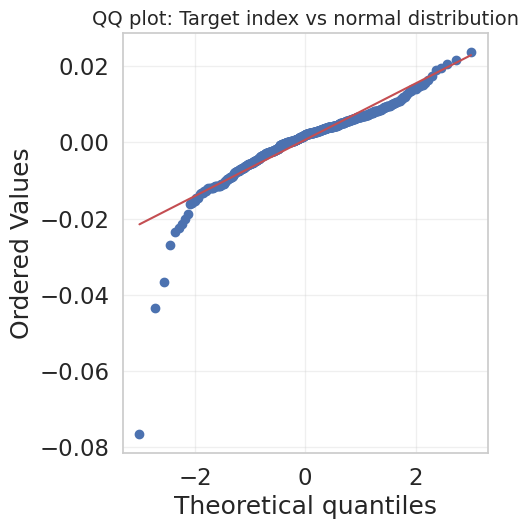

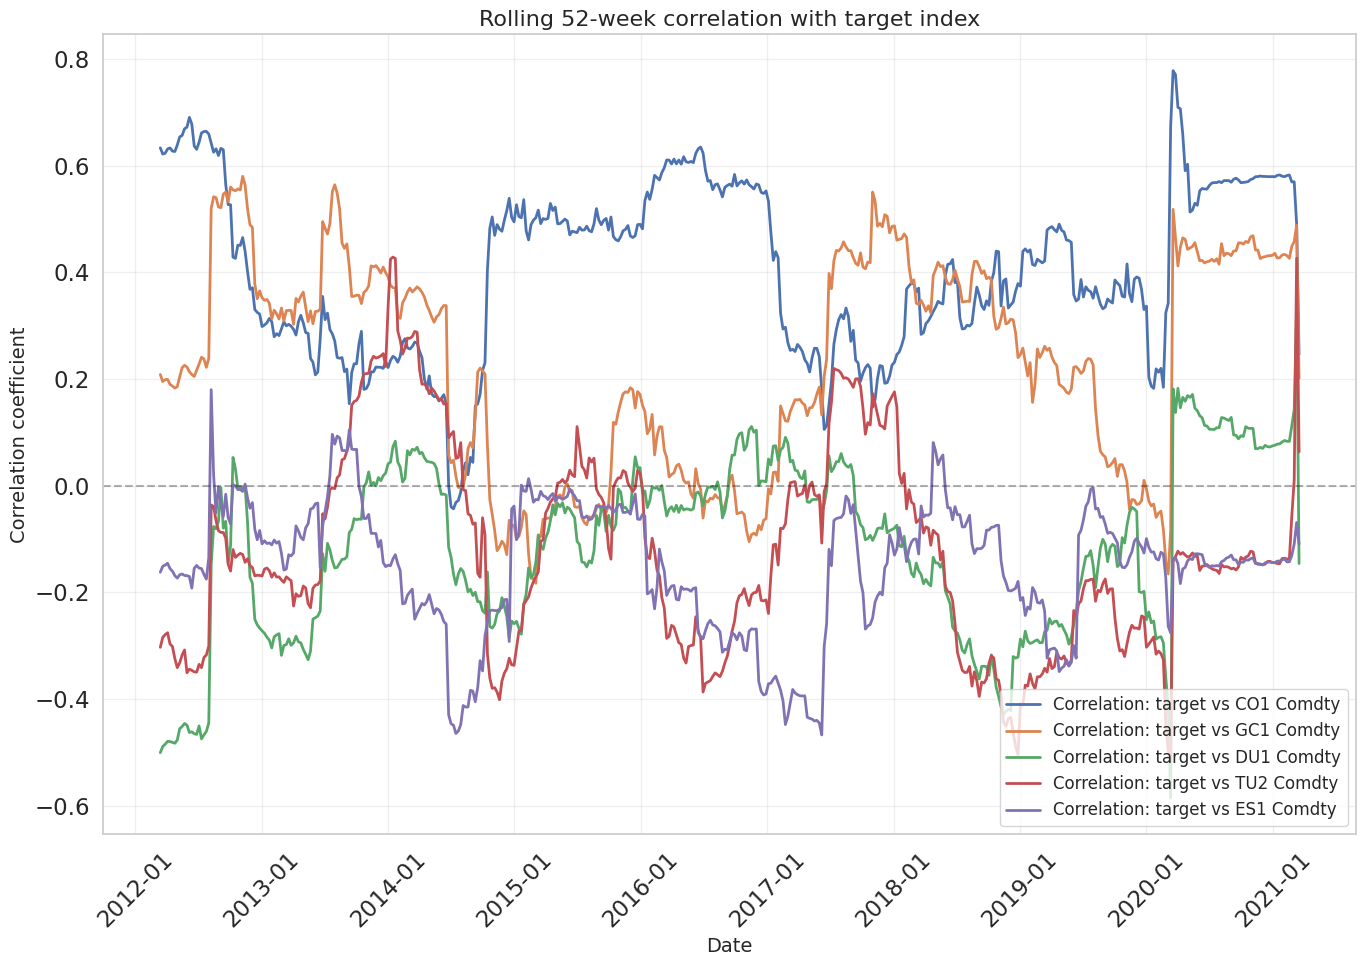

In [5]:
import scipy.stats as stats
import matplotlib.dates as mdates
from statsmodels.graphics.gofplots import qqplot
import warnings

# Suppress specific boring RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

# Define the components of our target index with their weights
# You can be creative, this is just an example
# Monster Index (a crazy combination of large indexes)
index_components = {
    'HFRXGL Index': 0.50,   # Hedge Fund Index - 50%
    'MXWO Index': 0.25,     # MSCI World - 25%
    'LEGATRUU Index': 0.25  # Global Aggregate Bond - 25%
}

# Calculate returns for each component
component_returns = data[list(index_components.keys())].pct_change().dropna()

# Create the target index using weighted returns
weighted_returns = pd.DataFrame(index=component_returns.index)
for component, weight in index_components.items():
    weighted_returns[component] = component_returns[component] * weight

# Sum the weighted returns to get the target index returns
target_returns = weighted_returns.sum(axis=1)
target_returns.name = 'Target_Index'

# Define the futures contracts we'll use for replication
futures_contracts = [
    'RX1 Comdty', 'TY1 Comdty', 'GC1 Comdty', 'CO1 Comdty',
    'ES1 Comdty', 'VG1 Comdty', 'NQ1 Comdty', 'LLL1 Comdty',
    'TP1 Comdty', 'DU1 Comdty', 'TU2 Comdty'
]

# Calculate returns for futures contracts
futures_returns = data[futures_contracts].pct_change().dropna()

# Ensure we're using the same date range for both target and futures
common_dates = futures_returns.index.intersection(target_returns.index)
futures_returns = futures_returns.loc[common_dates]
target_returns_aligned = target_returns.loc[common_dates]

# Calculate correlations between target index and futures contracts using pandas method
# which handles NaN values better than np.corrcoef
correlations = pd.DataFrame(index=futures_contracts,
                           columns=['Correlation with target index'])

for contract in futures_contracts:
    correlations.loc[contract] = target_returns_aligned.corr(futures_returns[contract])

# Sort by absolute correlation value
correlations['Abs correlation'] = correlations['Correlation with target index'].abs()
correlations = correlations.sort_values('Abs correlation', ascending=False)
correlations = correlations.drop('Abs correlation', axis=1)

# Now create the QQ plots
plt.figure(figsize=(16, 12))

# Plot QQ plot for the target index
plt.subplot(2, 3, 1)
stats.probplot(target_returns_aligned.dropna(), dist="norm", plot=plt)
plt.title(f'QQ plot: Target index vs normal distribution', fontsize=14)
plt.grid(True, alpha=0.3)

# Select a few key futures contracts (top 3 by correlation with target)
top_futures = correlations.index[:3].tolist()

# Plot rolling correlations between target index and Futures contracts
rolling_window = 52  # 52 weeks ≈ 1 year
plt.figure(figsize=(14, 10))

# Select top 5 futures by correlation (absolute value)
top_futures = correlations.index[:5].tolist()

for contract in top_futures:
    # Calculate rolling correlation
    combined_df = pd.DataFrame({
        'Target': target_returns_aligned,  # Fixed variable name
        'Future': futures_returns[contract]
    })
    rolling_corr = combined_df['Target'].rolling(rolling_window).corr(combined_df['Future'])

    # Plot
    plt.plot(rolling_corr.index, rolling_corr, linewidth=2,
             label=f"Correlation: target vs {contract}")

plt.title(f'Rolling {rolling_window}-week correlation with target index', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Correlation coefficient', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Models


In [35]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import math

# Ensure data is properly aligned
y = target_returns_aligned  # Target index returns
X = futures_returns.loc[y.index]  # Futures returns aligned with target

# Define hyperparameter grid - this is rough, on purpose: you can do better
l1_ratios = list(map(lambda x: round(x, 2), np.arange(0.0, 0.21, 0.05)))  # Generate l1_ratios with gaps of 0.2
rolling_windows = [52, 104, 156, 208]  # in weeks (1Y, 2Y, 3Y)
#alphas = list(map(lambda x: round(x, 2), np.arange(0.0001, 0.01, 0.0002)))
alphas = [0.1, 0.105]  # Regularization strength

# VaR parameters
var_confidence = 0.01  # 1% VaR
var_horizon = 4  # 4 weeks (1 month)
max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)

# Convert to numpy arrays for easier indexing
X_values = X.values
y_values = y.values
dates_array = X.index.to_numpy()

# Suppress boring warnings during the loop
import warnings
warnings.filterwarnings('ignore')

# Function to calculate VaR
def calculate_var(returns, confidence=0.01, horizon=4):
    """
    Calculate Value at Risk (VaR) using a simple Gaussian model (you can do better)

    Parameters:
    returns (array-like): Historical returns
    confidence (float): Confidence level (e.g., 0.01 for 1% VaR)
    horizon (int): Time horizon in weeks

    Returns:
    float: VaR as a positive number (loss)
    """
    # Calculate standard deviation of returns
    sigma = np.std(returns)

    # Calculate VaR using a Gaussian model
    # For a loss, we use the negative of the quantile
    # We use the negative of the quantile because VaR represents a loss
    # Note: this is just a a widespread and questionable practice (which I do not loke because it is ambiguous, there could be a positive VaR)
    z_score = stats.norm.ppf(confidence)

    # Scale to the desired time horizon
    var = -z_score * sigma * np.sqrt(horizon)

    return var

def calculate_historical_var(returns, confidence=0.01, horizon=4):
    """
    Calculate Value at Risk (VaR) using a simple Gaussian model (you can do better)

    Parameters:
    returns (array-like): Historical returns
    confidence (float): Confidence level (e.g., 0.01 for 1% VaR)
    horizon (int): Time horizon in weeks

    Returns:
    float: VaR as a positive number (loss)
    """

    loss = [-r for r in returns]
    loss_sorted = sorted(loss, reverse=True)
    n=len(returns)
    index=math.floor(n*confidence)
    var=loss[index]

    return var

# Function to run a single configuration with normalized returns and proper VaR scaling
def run_elastic_net_normalized(l1_ratio, rolling_window, alpha):
    # Initialize arrays to store results
    weights_history = []  # Store weights over time
    replica_returns = []  # Store replica portfolio returns
    target_dates = []  # Store dates for plotting
    gross_exposures = []  # Store gross exposure over time
    var_values = []  # Store VaR values over time
    scaling_factors = []  # Store scaling factors applied

    # Loop through the data using a rolling window approach as explained before
    for i in range(len(X) - rolling_window - 1):
        # Define training window
        start_idx = i
        end_idx = i + rolling_window

        # Extract training data
        X_train = X_values[start_idx:end_idx]
        y_train = y_values[start_idx:end_idx]

        # Normalize the training data using MinMaxScaler
        scaler_X = MinMaxScaler()
        X_train_normalized = scaler_X.fit_transform(X_train)

        # Normalize target
        scaler_y = MinMaxScaler()
        y_train_normalized = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

        # Fit Elastic Net model with a given alpha
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            fit_intercept=False,
            max_iter=10000,
            tol=1e-4
        )

        model.fit(X_train_normalized, y_train_normalized)

        # Get the normalized weights
        normalized_weights = model.coef_

        # Calculate weights for original scale
        original_weights = normalized_weights / scaler_X.scale_

        # Default scaling factor
        scaling_factor = 1.0

        # If we have enough historical data, calculate VaR and scale if needed
        if len(replica_returns) >= 12:  # Need some history to calculate VaR...
            # Calculate historical replica returns using current weights
            historical_returns = []
            for j in range(max(0, len(replica_returns)-52), len(replica_returns)):
                # Get historical futures returns for this period
                hist_returns = X_values[end_idx-(len(replica_returns)-j)]
                # Calculate weighted return
                weighted_return = np.dot(hist_returns, original_weights)
                historical_returns.append(weighted_return)

            # Calculate VaR
            var = calculate_historical_var(
                historical_returns,
                confidence=var_confidence,
                horizon=var_horizon
            )

            # Scale weights if VaR exceeds threshold
            if var > max_var_threshold:
                scaling_factor = max_var_threshold / var
                original_weights = original_weights * scaling_factor

                # Recalculate VaR after scaling to verify
                scaled_historical_returns = [ret * scaling_factor for ret in historical_returns]
                scaled_var = calculate_historical_var(
                    scaled_historical_returns,
                    confidence=var_confidence,
                    horizon=var_horizon
                )

                var = scaled_var  # Update VaR value after scaling

            var_values.append(var)
        else:
            var_values.append(np.nan)

        # Store scaling factor
        scaling_factors.append(scaling_factor)

        # Calculate gross exposure (sum of absolute weights) after scaling
        gross_exposure = np.sum(np.abs(original_weights))
        gross_exposures.append(gross_exposure)

        # Store the weights after scaling
        weights_history.append(original_weights)

        # Calculate replica return for the next period (t+1)
        next_returns = X_values[end_idx]  # This is t+1

        # Use scaled original weights with original returns
        replica_return = np.dot(next_returns, original_weights)

        replica_returns.append(replica_return)

        # Store the date for t+1
        target_dates.append(dates_array[end_idx])

    # Convert results to pandas series for easier analysis
    replica_returns_series = pd.Series(replica_returns, index=target_dates)

    # Calculate cumulative returns for both target and replica
    aligned_target = y.loc[replica_returns_series.index]
    cumulative_target = (1 + aligned_target).cumprod()
    cumulative_replica = (1 + replica_returns_series).cumprod()

    # Calculate performance metrics
    replica_mean_return = replica_returns_series.mean() * 52  # annualized
    target_mean_return = aligned_target.mean() * 52  # annualized

    replica_vol = replica_returns_series.std() * np.sqrt(52)  # annualized
    target_vol = aligned_target.std() * np.sqrt(52)  # annualized

    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else 0
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else 0

    # Calculate tracking error
    tracking_error = (replica_returns_series - aligned_target).std() * np.sqrt(52)
    information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else 0

    # Calculate drawdowns
    replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()
    target_drawdown = 1 - cumulative_target / cumulative_target.cummax()

    # Calculate correlation
    correlation = replica_returns_series.corr(aligned_target)

    # Calculate average gross exposure
    avg_gross_exposure = np.mean(gross_exposures)

    # Calculate average VaR (excluding NaN values)
    avg_var = np.nanmean(var_values)

    # Return all metrics
    return {
        'l1_ratio': l1_ratio,
        'rolling_window': rolling_window,
        'alpha': alpha,
        'replica_return': replica_mean_return,
        'target_return': target_mean_return,
        'replica_vol': replica_vol,
        'target_vol': target_vol,
        'replica_sharpe': replica_sharpe,
        'target_sharpe': target_sharpe,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'correlation': correlation,
        'max_drawdown': replica_drawdown.max(),
        'avg_gross_exposure': avg_gross_exposure,
        'avg_var': avg_var,
        'replica_returns': replica_returns_series,
        'aligned_target': aligned_target,
        'cumulative_replica': cumulative_replica,
        'cumulative_target': cumulative_target,
        'gross_exposures': gross_exposures,
        'var_values': var_values,
        'scaling_factors': scaling_factors,
        'weights_history': weights_history
    }

# Run all combinations with normalized returns
results_normalized = []

for l1_ratio, rolling_window, alpha in product(l1_ratios, rolling_windows, alphas):
    result = run_elastic_net_normalized(l1_ratio, rolling_window, alpha)
    results_normalized.append(result)

# Convert results to DataFrame for easier analysis
results_df_normalized = pd.DataFrame(results_normalized)

# Sort by information ratio (higher is better) - our primary objective
sorted_results_normalized = results_df_normalized.sort_values(by='information_ratio', ascending=False)

# Display top 10 configurations by information ratio
print("\nTop 10 configurations by information ratio (normalized returns):")
display(sorted_results_normalized[['l1_ratio', 'rolling_window', 'alpha', 'information_ratio', 'correlation',
                       'tracking_error', 'replica_sharpe', 'avg_gross_exposure', 'avg_var']].head(10))

# Get the best configuration by information ratio
best_config_normalized = sorted_results_normalized.iloc[0]
print(f"\nBest configuration by information ratio (normalized returns): l1_ratio={best_config_normalized['l1_ratio']}, "
      f"rolling_window={best_config_normalized['rolling_window']}, alpha={best_config_normalized['alpha']}")



Top 10 configurations by information ratio (normalized returns):


,l1_ratio,rolling_window,alpha,information_ratio,correlation,tracking_error,replica_sharpe,avg_gross_exposure,avg_var
1,0.00,52,0.105,0.603336,-0.011935,0.532190,0.684025,0.207783,-0.006220
0,0.00,52,0.100,0.601756,-0.011643,0.537470,0.681581,0.209522,-0.006302
3,0.00,104,0.105,0.568016,0.004907,0.441799,0.663139,0.263350,-0.011144
2,0.00,104,0.100,0.565830,0.005753,0.441164,0.661011,0.265635,-0.011282
5,0.00,156,0.105,0.523211,0.019663,0.446512,0.605805,0.323804,-0.003147
4,0.00,156,0.100,0.523057,0.020248,0.447898,0.605332,0.327066,-0.003175
9,0.05,52,0.105,0.500198,-0.007642,0.459754,0.593188,0.187914,-0.004016
8,0.05,52,0.100,0.500020,-0.007275,0.464755,0.591928,0.189873,-0.004117
12,0.05,156,0.100,0.465284,0.046632,0.298949,0.589092,0.271447,-0.001814
13,0.05,156,0.105,0.464936,0.046073,0.296665,0.589855,0.267659,-0.001776



Best configuration by information ratio (normalized returns): l1_ratio=0.0, rolling_window=52, alpha=0.105



Detailed metrics for the best configuration (normalized returns):


,Metric,Target,Replica
0,Annualized return,4.06%,36.16%
1,Annualized volatility,5.48%,52.87%
2,Sharpe ratio,0.74,0.68
3,Max Drawdown,40.85%,40.85%
4,Tracking Error,N/A,53.22%
5,Information ratio,N/A,0.60
6,Correlation,N/A,-0.0119
7,Average gross exposure,N/A,0.2078
8,"Average VaR (1%, 1M)",N/A,-0.62%


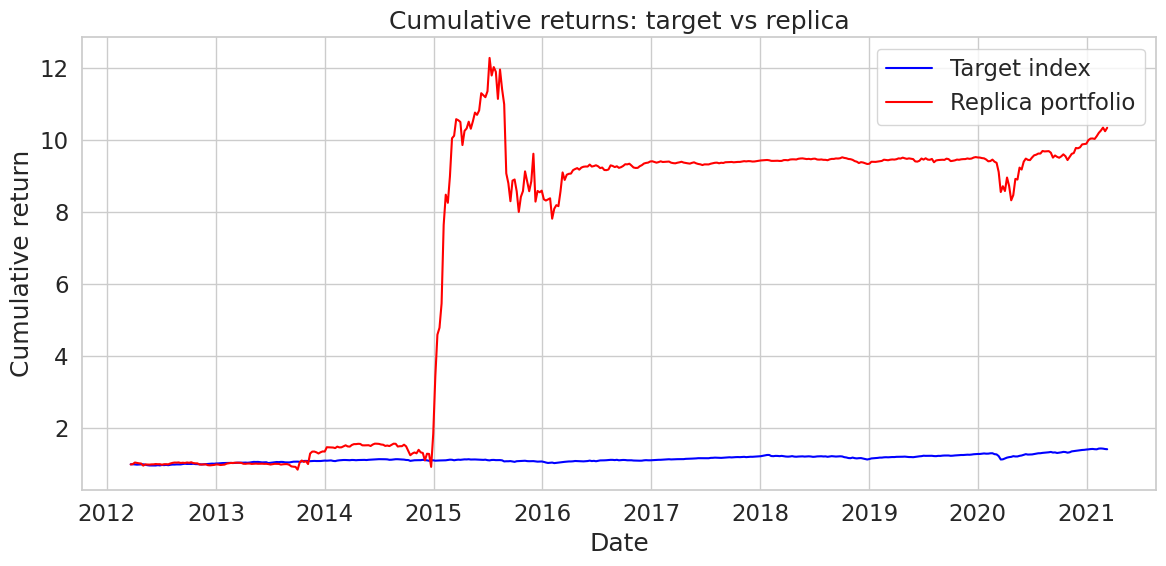

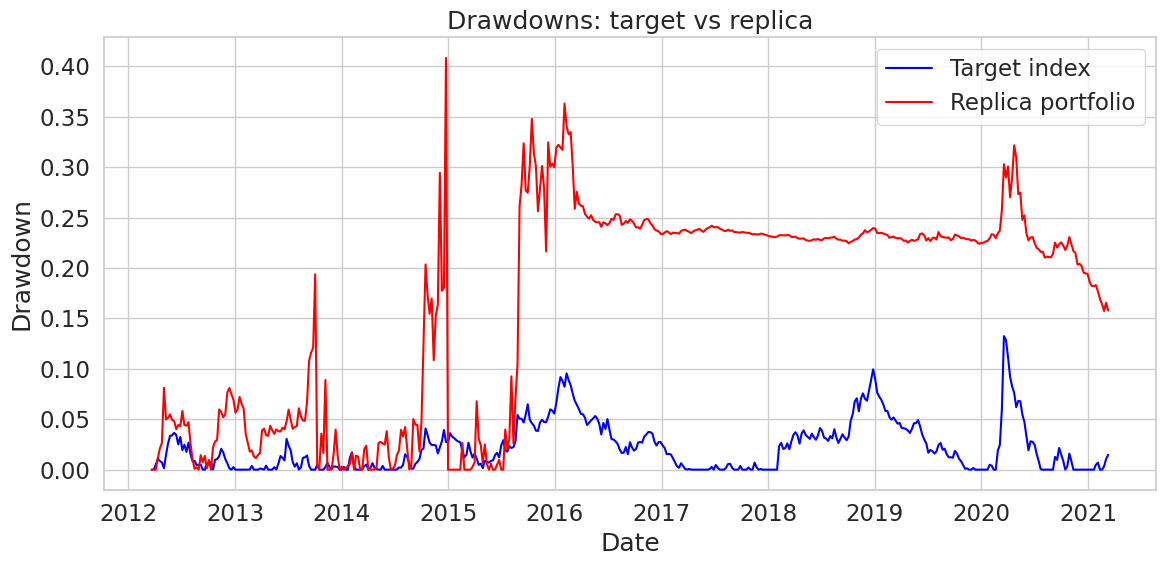

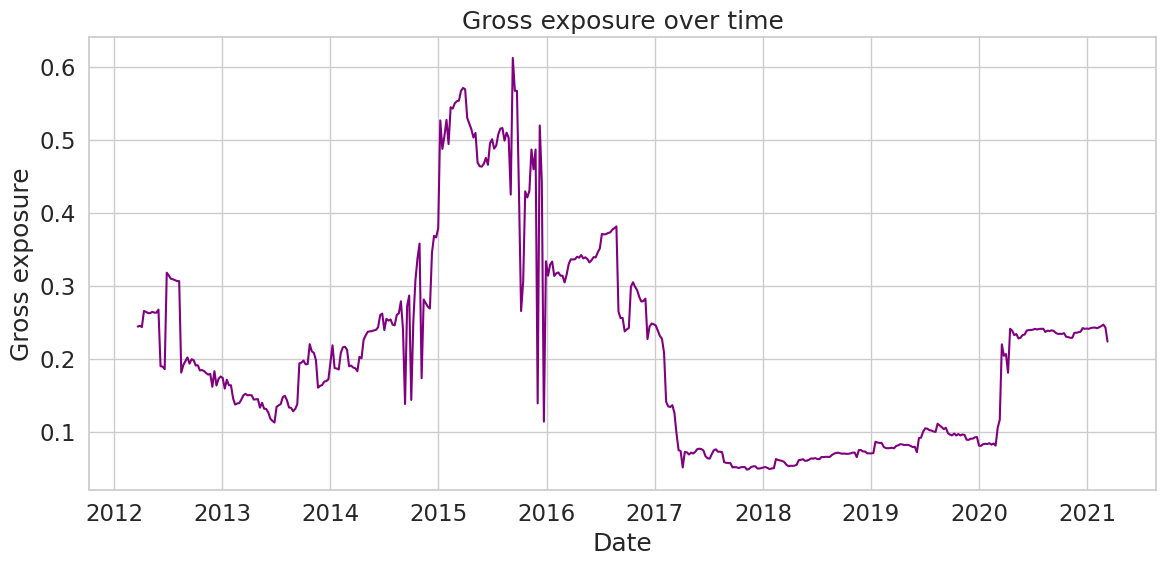

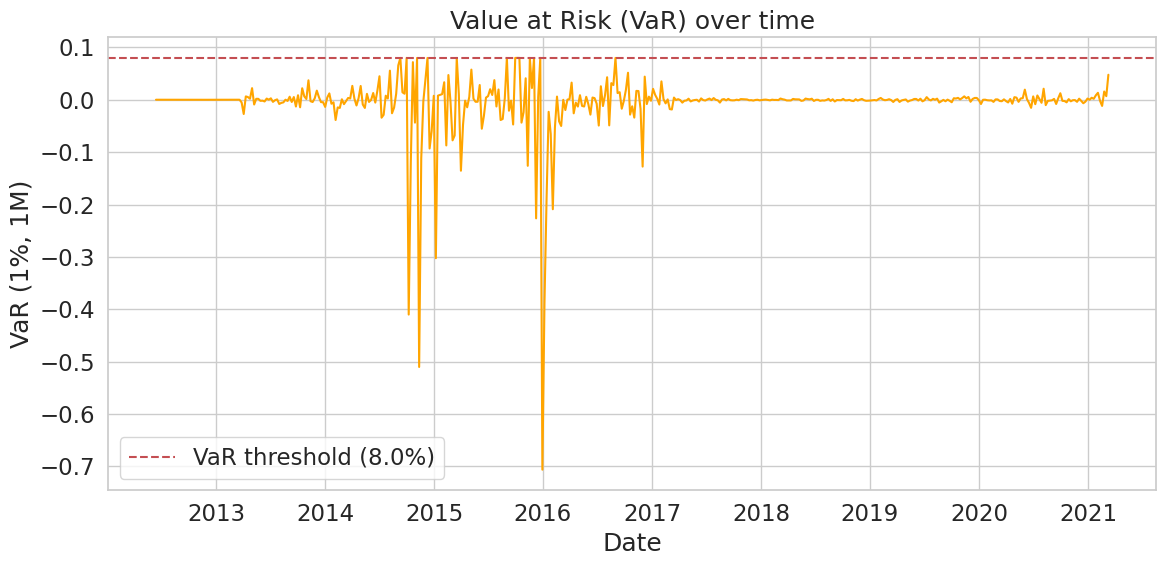

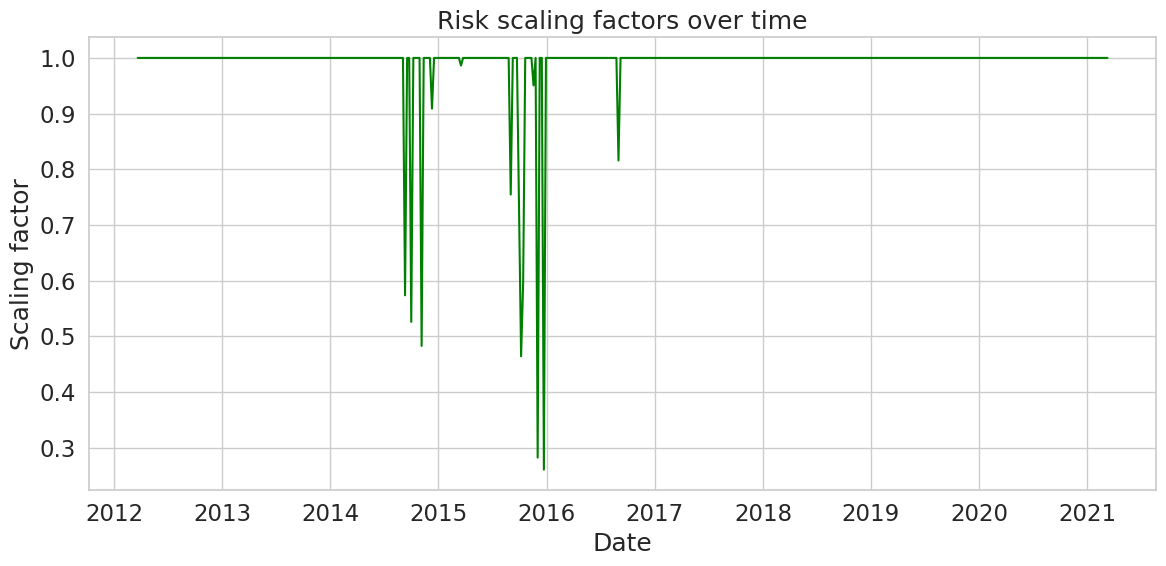

In [36]:
# Create detailed metrics table for the best configuration
metrics_normalized = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_config_normalized['target_return']*100:.2f}%",
               f"{best_config_normalized['target_vol']*100:.2f}%",
               f"{best_config_normalized['target_sharpe']:.2f}",
               f"{best_config_normalized['max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_config_normalized['replica_return']*100:.2f}%",
                f"{best_config_normalized['replica_vol']*100:.2f}%",
                f"{best_config_normalized['replica_sharpe']:.2f}",
                f"{best_config_normalized['max_drawdown']*100:.2f}%",
                f"{best_config_normalized['tracking_error']*100:.2f}%",
                f"{best_config_normalized['information_ratio']:.2f}",
                f"{best_config_normalized['correlation']:.4f}",
                f"{best_config_normalized['avg_gross_exposure']:.4f}",
                f"{best_config_normalized['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(best_config_normalized['cumulative_target'], label='Target index', color='blue')
plt.plot(best_config_normalized['cumulative_replica'], label='Replica portfolio', color='red')
plt.title('Cumulative returns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot drawdowns
plt.figure(figsize=(12, 6))
target_drawdown = 1 - best_config_normalized['cumulative_target'] / best_config_normalized['cumulative_target'].cummax()
replica_drawdown = 1 - best_config_normalized['cumulative_replica'] / best_config_normalized['cumulative_replica'].cummax()
plt.plot(target_drawdown, label='Target index', color='blue')
plt.plot(replica_drawdown, label='Replica portfolio', color='red')
plt.title('Drawdowns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot gross exposure over time
plt.figure(figsize=(12, 6))
gross_exposure_series = pd.Series(best_config_normalized['gross_exposures'], index=best_config_normalized['replica_returns'].index)
plt.plot(gross_exposure_series, color='purple')
plt.title('Gross exposure over time')
plt.xlabel('Date')
plt.ylabel('Gross exposure')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot VaR over time
plt.figure(figsize=(12, 6))
var_series = pd.Series(best_config_normalized['var_values'], index=best_config_normalized['replica_returns'].index)
plt.plot(var_series, color='orange')
plt.axhline(y=max_var_threshold, color='r', linestyle='--', label=f'VaR threshold ({max_var_threshold*100}%)')
plt.title('Value at Risk (VaR) over time')
plt.xlabel('Date')
plt.ylabel('VaR (1%, 1M)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot scaling factors over time
plt.figure(figsize=(12, 6))
scaling_series = pd.Series(best_config_normalized['scaling_factors'], index=best_config_normalized['replica_returns'].index)
plt.plot(scaling_series, color='green')
plt.title('Risk scaling factors over time')
plt.xlabel('Date')
plt.ylabel('Scaling factor')
plt.grid(True)
plt.tight_layout()
plt.show()

# Kalman Filter 

In [29]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Function to calculate VaR (unchanged from original code)
def calculate_var(returns, confidence=0.01, horizon=4):
    """
    Calculate Value at Risk (VaR) using a simple Gaussian model
    
    Parameters:
    returns (array-like): Historical returns
    confidence (float): Confidence level (e.g., 0.01 for 1% VaR)
    horizon (int): Time horizon in weeks
    
    Returns:
    float: VaR as a positive number (loss)
    """
    # Calculate standard deviation of returns
    sigma = np.std(returns)
    
    # Calculate VaR using a Gaussian model
    z_score = stats.norm.ppf(confidence)
    
    # Scale to the desired time horizon
    var = -z_score * sigma * np.sqrt(horizon)
    
    return var

class KalmanFilterReplication:
    """
    Kalman Filter implementation for portfolio replication
    """
    def __init__(self, process_var=1e-4, observation_var=1e-2, initial_state_var=1e-2):
        self.process_var = process_var  # Process noise variance (Q)
        self.observation_var = observation_var  # Observation noise variance (R)
        self.initial_state_var = initial_state_var  # Initial state variance (P0)
        self.weights = None  # Current state estimate
        self.covariance = None  # Current state covariance
        self.initialized = False
    
    def initialize(self, n_assets, initial_weights=None):
        """Initialize the filter with optional initial weights"""
        if initial_weights is not None:
            self.weights = initial_weights
        else:
            self.weights = np.zeros(n_assets)
        
        # Initialize state covariance matrix
        self.covariance = np.eye(n_assets) * self.initial_state_var
        self.initialized = True
    
    def update(self, returns, target_return):
        """
        Update the Kalman filter with new observation
        
        Parameters:
        returns (np.array): Asset returns vector
        target_return (float): Target portfolio return
        
        Returns:
        np.array: Updated weights
        """
        if not self.initialized:
            raise ValueError("Kalman filter must be initialized first")
        
        n_assets = len(returns)
        
        # Prediction step (A = I, assuming random walk)
        # x_t|t-1 = x_t-1|t-1 (no change in prediction)
        # P_t|t-1 = P_t-1|t-1 + Q
        process_noise = np.eye(n_assets) * self.process_var
        predicted_covariance = self.covariance + process_noise
        
        # Kalman gain
        # K_t = P_t|t-1 * H^T * (H * P_t|t-1 * H^T + R)^-1
        # Where H = returns (observation matrix)
        denominator = np.dot(returns, np.dot(predicted_covariance, returns)) + self.observation_var
        kalman_gain = np.dot(predicted_covariance, returns) / denominator
        
        # Update step
        # x_t|t = x_t|t-1 + K_t * (y_t - H * x_t|t-1)
        prediction_error = target_return - np.dot(returns, self.weights)
        self.weights = self.weights + kalman_gain * prediction_error
        
        # Update covariance
        # P_t|t = (I - K_t * H) * P_t|t-1
        self.covariance = predicted_covariance - np.outer(kalman_gain, returns).dot(predicted_covariance)
        
        return self.weights.copy()

# Function to run portfolio replication with Kalman Filter
def run_kalman_filter_replication(
    X, y, 
    process_var=1e-4, 
    observation_var=1e-2,
    initial_state_var=1e-2,
    initial_window=52,
    rebalance_freq=1,
    transaction_cost_bps=5,
    var_confidence=0.01,
    var_horizon=4,
    max_var_threshold=0.08,
    ridge_alpha=0.1
):
    """
    Run portfolio replication using Kalman Filter
    
    Parameters:
    X (DataFrame): Futures returns
    y (Series): Target index returns
    process_var (float): Process noise variance
    observation_var (float): Observation noise variance
    initial_state_var (float): Initial state variance
    initial_window (int): Initial window size to initialize weights
    rebalance_freq (int): Rebalancing frequency in weeks
    transaction_cost_bps (float): Transaction cost in basis points
    var_confidence (float): VaR confidence level
    var_horizon (int): VaR time horizon
    max_var_threshold (float): Maximum VaR threshold
    ridge_alpha (float): Alpha for Ridge regression initialization
    
    Returns:
    dict: Results including performance metrics
    """
    # Convert to numpy arrays for easier indexing
    X_values = X.values
    y_values = y.values
    dates_array = X.index.to_numpy()
    
    n_assets = X.shape[1]
    
    # Initialize arrays to store results
    weights_history = []  # Store weights over time
    replica_returns = []  # Store replica portfolio returns
    target_dates = []  # Store dates for plotting
    gross_exposures = []  # Store gross exposure over time
    var_values = []  # Store VaR values over time
    scaling_factors = []  # Store scaling factors applied
    transaction_costs = []  # Store transaction costs
    
    # Initialize Kalman Filter
    kf = KalmanFilterReplication(
        process_var=process_var,
        observation_var=observation_var,
        initial_state_var=initial_state_var
    )
    
    # Use Ridge regression to initialize weights with the initial window
    ridge = Ridge(alpha=ridge_alpha, fit_intercept=False)
    ridge.fit(X_values[:initial_window], y_values[:initial_window])
    initial_weights = ridge.coef_
    
    # Initialize Kalman Filter with Ridge weights
    kf.initialize(n_assets, initial_weights)
    
    # Current portfolio weights
    current_weights = initial_weights.copy()
    
    # Loop through the data starting after the initial window
    for i in range(initial_window, len(X) - 1):
        # Only update weights on rebalancing dates
        if (i - initial_window) % rebalance_freq == 0:
            # Get current returns data
            current_returns = X_values[i]
            current_target = y_values[i]
            
            # Update weights using Kalman Filter
            new_weights = kf.update(current_returns, current_target)
            
            # Default scaling factor
            scaling_factor = 1.0
            
            # If we have enough historical data, calculate VaR and scale if needed
            if len(replica_returns) >= 12:
                # Calculate historical replica returns using current weights
                historical_returns = []
                for j in range(max(0, len(replica_returns)-52), len(replica_returns)):
                    # Get historical futures returns for this period
                    hist_returns = X_values[initial_window+j]
                    # Calculate weighted return
                    hist_weighted_return = np.dot(hist_returns, current_weights)
                    historical_returns.append(hist_weighted_return)
                
                # Calculate VaR
                var = calculate_var(
                    historical_returns,
                    confidence=var_confidence,
                    horizon=var_horizon
                )
                
                # Scale weights if VaR exceeds threshold
                if var > max_var_threshold:
                    scaling_factor = max_var_threshold / var
                    new_weights = new_weights * scaling_factor
                    
                    # Recalculate VaR after scaling to verify
                    scaled_historical_returns = [ret * scaling_factor for ret in historical_returns]
                    var = calculate_var(
                        scaled_historical_returns,
                        confidence=var_confidence,
                        horizon=var_horizon
                    )
                
                var_values.append(var)
            else:
                var_values.append(np.nan)
            
            # Calculate transaction costs as a percentage of portfolio value
            # Transaction cost = sum(abs(new_weights - current_weights)) * transaction_cost_bps / 10000
            turnover = np.sum(np.abs(new_weights - current_weights))
            transaction_cost = turnover * transaction_cost_bps / 10000  # Convert bps to percentage
            transaction_costs.append(transaction_cost)
            
            # Store scaling factor
            scaling_factors.append(scaling_factor)
            
            # Update current weights
            current_weights = new_weights.copy()
        else:
            # If not rebalancing, continue with current weights
            scaling_factors.append(1.0)
            transaction_costs.append(0.0)
        
        # Calculate gross exposure (sum of absolute weights)
        gross_exposure = np.sum(np.abs(current_weights))
        gross_exposures.append(gross_exposure)
        
        # Store the current weights
        weights_history.append(current_weights.copy())
        
        # Calculate replica return for the next period (t+1) including transaction costs
        next_returns = X_values[i+1]
        replica_return = np.dot(next_returns, current_weights)
        
        # Apply transaction costs if rebalanced
        if (i - initial_window) % rebalance_freq == 0:
            replica_return -= transaction_costs[-1]
        
        replica_returns.append(replica_return)
        
        # Store the date for t+1
        target_dates.append(dates_array[i+1])
    
    # Convert results to pandas series for easier analysis
    replica_returns_series = pd.Series(replica_returns, index=target_dates)
    
    # Calculate cumulative returns for both target and replica
    aligned_target = y.loc[replica_returns_series.index]
    cumulative_target = (1 + aligned_target).cumprod()
    cumulative_replica = (1 + replica_returns_series).cumprod()
    
    # Calculate performance metrics
    replica_mean_return = replica_returns_series.mean() * 52  # annualized
    target_mean_return = aligned_target.mean() * 52  # annualized
    
    replica_vol = replica_returns_series.std() * np.sqrt(52)  # annualized
    target_vol = aligned_target.std() * np.sqrt(52)  # annualized
    
    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else 0
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else 0
    
    # Calculate tracking error
    tracking_error = (replica_returns_series - aligned_target).std() * np.sqrt(52)
    information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else 0
    
    # Calculate drawdowns
    replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()
    target_drawdown = 1 - cumulative_target / cumulative_target.cummax()
    
    # Calculate correlation
    correlation = replica_returns_series.corr(aligned_target)
    
    # Calculate average gross exposure
    avg_gross_exposure = np.mean(gross_exposures)
    
    # Calculate average VaR (excluding NaN values)
    avg_var = np.nanmean(var_values)
    
    # Calculate average transaction cost
    avg_transaction_cost = np.mean(transaction_costs) * 52  # annualized
    
    # Create weights DataFrame for easier analysis
    weights_df = pd.DataFrame(weights_history, index=target_dates, columns=X.columns)
    
    # Return all metrics
    return {
        'model': 'Kalman Filter',
        'process_var': process_var,
        'observation_var': observation_var,
        'initial_state_var': initial_state_var,
        'initial_window': initial_window,
        'rebalance_freq': rebalance_freq,
        'transaction_cost_bps': transaction_cost_bps,
        'replica_return': replica_mean_return,
        'target_return': target_mean_return,
        'replica_vol': replica_vol,
        'target_vol': target_vol,
        'replica_sharpe': replica_sharpe,
        'target_sharpe': target_sharpe,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'correlation': correlation,
        'max_drawdown': replica_drawdown.max(),
        'avg_gross_exposure': avg_gross_exposure,
        'avg_var': avg_var,
        'avg_transaction_cost': avg_transaction_cost,
        'replica_returns': replica_returns_series,
        'aligned_target': aligned_target,
        'cumulative_replica': cumulative_replica,
        'cumulative_target': cumulative_target,
        'gross_exposures': gross_exposures,
        'var_values': var_values,
        'scaling_factors': scaling_factors,
        'transaction_costs': transaction_costs,
        'weights_history': weights_df
    }

# Function to run grid search for Kalman Filter
def grid_search_kalman_filter(X, y):
    """
    Run grid search for Kalman Filter hyperparameters
    
    Parameters:
    X (DataFrame): Futures returns
    y (Series): Target index returns
    
    Returns:
    DataFrame: Results of grid search
    """
    # Define parameter grid
    process_vars = [1e-6, 1e-5, 1e-4, 1e-3]
    observation_vars = [1e-3, 1e-2, 1e-1]
    initial_windows = [52, 104]
    rebalance_freqs = [1, 4, 12]
    
    # Store results
    results = []
    
    # Run grid search
    for process_var, observation_var, initial_window, rebalance_freq in product(
        process_vars, observation_vars, initial_windows, rebalance_freqs
    ):
        result = run_kalman_filter_replication(
            X, y,
            process_var=process_var,
            observation_var=observation_var,
            initial_window=initial_window,
            rebalance_freq=rebalance_freq,
            transaction_cost_bps=5
        )
        
        # Extract only the most important metrics for the grid search
        summary = {
            'process_var': process_var,
            'observation_var': observation_var,
            'initial_window': initial_window,
            'rebalance_freq': rebalance_freq,
            'information_ratio': result['information_ratio'],
            'correlation': result['correlation'],
            'tracking_error': result['tracking_error'],
            'replica_sharpe': result['replica_sharpe'],
            'avg_transaction_cost': result['avg_transaction_cost']
        }
        
        results.append(summary)
    
    # Convert to DataFrame and sort by information ratio
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='information_ratio', ascending=False)
    
    return sorted_results


In [33]:
sorted_results_normalized = grid_search_kalman_filter(X, y)
# Get the best configuration by information ratio
best_config_normalized = sorted_results_normalized.iloc[0]
print(f"\nBest configuration by information ratio (Kalman Filter): process_var={best_config_normalized['process_var']}, "
      f"observation_var={best_config_normalized['observation_var']}, "
      f"initial_window={best_config_normalized['initial_window']}, "
      f"rebalance_freq={best_config_normalized['rebalance_freq']}")

# Run the full model with best parameters to get detailed results
best_model_results = run_kalman_filter_replication(
    X, y,
    process_var=best_config_normalized['process_var'],
    observation_var=best_config_normalized['observation_var'],
    initial_window=best_config_normalized['initial_window'],
    rebalance_freq=best_config_normalized['rebalance_freq'],
    transaction_cost_bps=5  # 5 basis points per trade
)


Best configuration by information ratio (Kalman Filter): process_var=0.001, observation_var=0.001, initial_window=104.0, rebalance_freq=1.0


TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
# Create detailed metrics table for the best configuration
metrics_normalized = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{best_model_results['target_return']*100:.2f}%",
               f"{best_model_results['target_vol']*100:.2f}%",
               f"{best_model_results['target_sharpe']:.2f}",
               f"{best_model_results['max_drawdown']*100:.2f}%",
               "N/A",
               "N/A",
               "N/A",
               "N/A",
               "N/A"],
    'Replica': [f"{best_model_results['replica_return']*100:.2f}%",
                f"{best_model_results['replica_vol']*100:.2f}%",
                f"{best_model_results['replica_sharpe']:.2f}",
                f"{best_model_results['max_drawdown']*100:.2f}%",
                f"{best_model_results['tracking_error']*100:.2f}%",
                f"{best_model_results['information_ratio']:.2f}",
                f"{best_model_results['correlation']:.4f}",
                f"{best_model_results['avg_gross_exposure']:.4f}",
                f"{best_model_results['avg_var']*100:.2f}%"]
})

print("\nDetailed metrics for the best configuration (normalized returns):")
display(metrics_normalized)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(best_model_results['cumulative_target'], label='Target index', color='blue')
plt.plot(best_model_results['cumulative_replica'], label='Replica portfolio', color='red')
plt.title('Cumulative returns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot drawdowns
plt.figure(figsize=(12, 6))
target_drawdown = 1 - best_model_results['cumulative_target'] / best_model_results['cumulative_target'].cummax()
replica_drawdown = 1 - best_model_results['cumulative_replica'] / best_model_results['cumulative_replica'].cummax()
plt.plot(target_drawdown, label='Target index', color='blue')
plt.plot(replica_drawdown, label='Replica portfolio', color='red')
plt.title('Drawdowns: target vs replica')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot gross exposure over time
plt.figure(figsize=(12, 6))
gross_exposure_series = pd.Series(best_model_results['gross_exposures'], index=best_model_results['replica_returns'].index)
plt.plot(gross_exposure_series, color='purple')
plt.title('Gross exposure over time')
plt.xlabel('Date')
plt.ylabel('Gross exposure')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot VaR over time
plt.figure(figsize=(12, 6))
var_series = pd.Series(best_model_results['var_values'], index=best_model_results['replica_returns'].index)
plt.plot(var_series, color='orange')
plt.axhline(y=max_var_threshold, color='r', linestyle='--', label=f'VaR threshold ({max_var_threshold*100}%)')
plt.title('Value at Risk (VaR) over time')
plt.xlabel('Date')
plt.ylabel('VaR (1%, 1M)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot scaling factors over time
plt.figure(figsize=(12, 6))
scaling_series = pd.Series(best_model_results['scaling_factors'], index=best_model_results['replica_returns'].index)
plt.plot(scaling_series, color='green')
plt.title('Risk scaling factors over time')
plt.xlabel('Date')
plt.ylabel('Scaling factor')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'target_return'